 # Temporal analysis with gammapy
 
 - PKS 2155-304 flare runs from the HESS Public data release
 - Assume template background already made using https://docs.gammapy.org/dev/notebooks/background_model.html
 - Do a 3D map based analysis keeping only the amplitude free


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import os
from pathlib import Path

from astropy.coordinates import SkyCoord, Angle

from gammapy.data import ObservationFilter, DataStore, DataStoreObservation
from gammapy.irf import EffectiveAreaTable2D, EnergyDispersion2D, EnergyDependentMultiGaussPSF, Background3D
from gammapy.spectrum.models import PowerLaw, PowerLaw2
from gammapy.image.models import SkyPointSource
from gammapy.cube import MapEvaluator, PSFKernel, MapMaker, MapMakerObs, MapDataset
from gammapy.utils.fitting import Fit
from gammapy.cube import make_map_exposure_true_energy, make_map_background_irf
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap, Map
from gammapy.cube.models import SkyModel, SkyModels, BackgroundModel
from gammapy.cube.exposure import _map_spectrum_weight
from astropy.time import Time
from regions import CircleSkyRegion
from gammapy.irf import make_mean_psf


### Load the data - standard process - use the hdu-index-table with the background files

In [2]:
#Get DR1 data

path = (
    Path(os.environ["GAMMAPY_DATA"])
    / "hess-dl3-dr1/hess-dl3-dr3-with-background.fits.gz"
)
datastore = DataStore.from_file(path)
src=SkyCoord.from_name("PKS 2155-304")
sep=SkyCoord.separation(src,datastore.obs_table.pointing_radec)
Radius=2.3
srcruns=(datastore.obs_table[sep<Radius*u.deg])
myid=srcruns['OBS_ID'].data
mylist=datastore.get_observations(myid)

## Steps for standard 3D analysis

Standard 3D analysis as explained in analysis_3d will be performed for each time bin.

In [3]:
# Define geoms
emin, emax = [0.1, 10] * u.TeV
energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, 10, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=src,
    binsz=0.02,
    width=(10, 8),
    coordsys="CEL",
    proj="CAR",
    axes=[energy_axis],
)

In [4]:
# Define the source model - Use a pointsource + integrated power law model to directly get flux

spatial_model = SkyPointSource(lon_0=src.ra, lat_0=src.dec, frame="icrs")
spectral_model = PowerLaw2(
    emin=emin, emax=emax, index=2.0, amplitude="3e-10 cm-2 s-1"
)
sky_model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)
sky_model.parameters["index"].frozen = True
sky_model.parameters["lon_0"].frozen = True
sky_model.parameters["lat_0"].frozen = True
sky_model.parameters["amplitude"].min = 0.0

In [5]:
region = CircleSkyRegion(center=src, radius=0.6 * u.deg)

In [6]:
# psf_kernel and MapMaker for each segment
def make_maps(observations):
    maker = MapMaker(geom, offset_max=2.0 * u.deg)
    spectrum = PowerLaw2(index=2)
    maps2D = maker.run_images(observations, spectrum=spectrum, keepdims=True)
    geom2d = maps2D["exposure"].geom
    
    table_psf = make_mean_psf(observations,src)

    table_psf_2d = table_psf.table_psf_in_energy_band(
    (emin, emax), spectrum=spectrum)

    # PSF kernel used for the model convolution
    psf_kernel = PSFKernel.from_table_psf(
        table_psf_2d, geom2d, max_radius="0.3 deg"
        )
    
    return maps2D, psf_kernel

### Choose the time binning - PKS flare example

From the DR1 paper, we can see that the flare runs are taken on the night 2006-07-29 - 2006-07-30.
We make 5 min bins.

In [7]:
time_start = Time("2006-07-29 20:00:00.000")
time_stop = Time("2006-07-30 06:00:00.00")
time_step = 5.0 * u.min
time_0 = time_start

In [8]:
%%time

map_segments = []
psf_segments = []

mjd = []
while time_start<time_stop:
    
    # get smaller observation lists
    t2 = time_start+time_step
    time_interval = Time([time_start.value, t2.value])
    obs = mylist.select_time(time_interval)
    
    
    #Proceed with further analysis only if there are observations in the selected time window
    if len(obs) > 0: 
        
        maps, psf = make_maps(obs)
        map_segments.append(maps)
        psf_segments.append(psf)
        
        mjd.append((time_start+time_step/2.0).mjd)
    time_start = t2

CPU times: user 10min 27s, sys: 32.1 s, total: 10min 59s
Wall time: 3min 57s


In [9]:
#Quick look excess
excess_counts = []
excess_err = []
for amap in map_segments:
    excess = amap['counts'] - amap['background']
    mask = amap['counts'].geom.region_mask([region])
    excess = excess * mask
    c_err = np.sqrt((amap['counts']*mask).data.sum())
    b_err = np.sqrt((amap['background']*mask).data.sum())
    excess_counts.append(excess.data.sum())
    excess_err.append(c_err+b_err)


Text(0,0.5,'Excess counts')

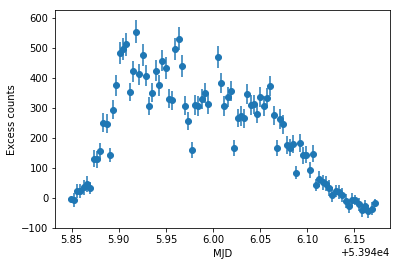

In [10]:
plt.errorbar(mjd,excess_counts,yerr=excess_err,fmt="o")    
plt.xlabel("MJD")
plt.ylabel("Excess counts")

The binning seems reasonable. Now, do a 3D fitting to get proper flux

In [11]:
%%time
flux = []
flux_err = []
for amap,psf in zip(map_segments,psf_segments):
    
    #Copy the source model
    model = sky_model.copy()
    
    # Make the background model
    background_model = BackgroundModel(amap["background"])
    background_model.parameters["norm"].frozen = True
    background_model.parameters["tilt"].frozen = True
          
    #Now fit
    dataset = MapDataset(
        model=model,
        counts=amap["counts"],
        exposure=amap["exposure"],
        background_model=background_model,
        mask_fit=mask,
        psf=psf,
    )
        
    fit = Fit(dataset)
    result = fit.run()
    flux.append(model.parameters['amplitude'].value)
    flux_err.append(result.parameters.error('amplitude'))

CPU times: user 1min 16s, sys: 2.22 s, total: 1min 18s
Wall time: 19.8 s


Text(0,0.5,'flux')

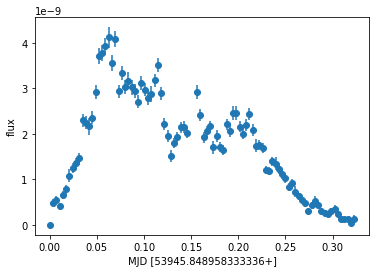

In [12]:
plt.errorbar(np.subtract(mjd,mjd[0]),flux,yerr=flux_err,fmt="o")    
plt.xlabel("MJD [" + str(mjd[0]) + "+]")
plt.ylabel("flux")